### split the data

In [1]:
# Follow the data split rate, randomly seperate images into 2 groups --train and validation, with correspinding 
# annotations, then save the images and annotation json file sets in the different directory (train & validation)

from glob import glob
import json
import shutil
from random import random, shuffle

def splitDataset(imgpath_input, annotpath_input, path_output_val, path_output_train, split_rate):
    image_paths = glob(imgpath_input)
    shuffle(image_paths)
    # image_paths = imgpath
    # print(image_paths)
    # Path to your annotations from VIA tool
    annotation_file = annotpath_input
    # clean up the annotations a little
    annotations = json.load(open(annotation_file))
    # print(annotations)
    cleaned_annotations = {}
    for k, v in annotations['_via_img_metadata'].items():
        cleaned_annotations[v['filename']] = v

    train_annotations = {}
    valid_annotations = {}
    validation_size = round(len(image_paths)*split_rate)
    # size of images in validation folder
    for img in image_paths[:validation_size]:
        # Image goes to Validation folder
        shutil.copy2(img, path_output_val)
        img = img.split("/")[-1]
        valid_annotations[img] = cleaned_annotations[img]
    for img in image_paths[validation_size:]:
        shutil.copy2(img, path_output_train)
        img = img.split("/")[-1]
        train_annotations[img] = cleaned_annotations[img]
    # put different annotations in different folders
    with open(path_output_val + 'via_region_data.json', 'w') as fp:
        json.dump(valid_annotations, fp)
    with open(path_output_train + 'via_region_data.json', 'w') as fp:
        json.dump(train_annotations, fp)
    print("+++++ finish split dataset +++++")

In [2]:
#Split the data
path_input = "/home/ada/Mask_RCNN/Colonocopy_Doc/datastore/colon_datastore/*"
annot_input = "/home/ada/Mask_RCNN/Colonocopy_Doc/datastore/anottation_dataset/new_hollow.json"
path_output_val = "/home/ada/Mask_RCNN/Colonocopy_Doc/dataset_for_train/val/"
path_output_train = "/home/ada/Mask_RCNN/Colonocopy_Doc/dataset_for_train/train/"
# 20% Image goes to Validation folder
splitDataset(path_input, annot_input, path_output_val, path_output_train, 0.2)

+++++ finish split dataset +++++


### Create train and Validation Dataset

In [108]:
import sys
import utils
import numpy as np
import skimage.draw
import os
import json


class PolypsDataset(utils.Dataset):
    """
    preparing dataset for training
    """

    def load_polyps(self, dataset_dir, subset):
        """
        :param dataset_dir: the parent directory containing our training data folders (train, val)
        :param subset: which dataset choosing, training or validation
        """
        # Add classes. We have only one class to add.
        self.add_class("polyp", 1, "polyp")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print(dataset_dir)
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]

        for a in annotations:

            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                # sample of polygons elements: 
                # {"name": "polygon", 
                #  "all_points_x": [345, 435, 552, 625, 679, 717, 725, 694, 597, 536, 439, 367, 347], 
                #  "all_points_y": [420, 357, 321, 312, 340, 399, 466, 532, 564, 572, 569, 527, 495]}

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "polyp",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):

        image_info = self.image_info[image_id]
        if image_info["source"] != "polyp":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
 
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "polyp":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [74]:
dataset_dir = "/home/slender/Documents/Mask_RCNN/hollow_dataset/"
# generate the train set
train_set = PolypsDataset()
train_set.load_polyps(dataset_dir, 'train')
train_set.prepare()
# print("Images: {}\nClasses: {}".format(len(train_set.image_ids), dataset.class_names))
print("Train Image Count: {}".format(len(train_set.image_ids)))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

/home/slender/Documents/Mask_RCNN/hollow_dataset/train
Train Image Count: 788
Class Count: 2
  0. BG                                                
  1. polyp                                             


In [109]:
# generate the validation set
val_set = PolypsDataset()
val_set.load_polyps(dataset_dir, 'val')
val_set.prepare()
# print("Images: {}\nClasses: {}".format(len(val_set.image_ids), dataset.class_names))
print("Validation Image Count: {}".format(len(val_set.image_ids)))
print("Class Count: {}".format(val_set.num_classes))
for i, info in enumerate(val_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

/home/slender/Documents/Mask_RCNN/hollow_dataset/val
Validation Image Count: 196
Class Count: 2
  0. BG                                                
  1. polyp                                             


### visualization

image shape:  (1944, 1944, 3)
mask shape:  (1944, 1944, 1)
class id:  [1]
<class 'numpy.ndarray'>


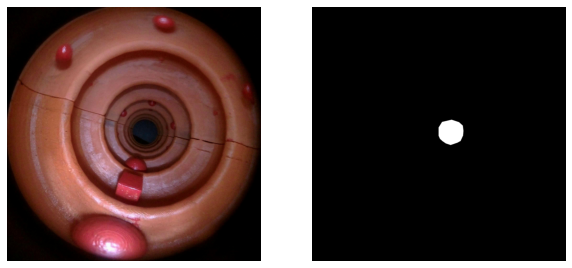

In [69]:
# Load and display random sample and their bounding boxes

import matplotlib.pyplot as plt
import random
import numpy as np

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(val_set.image_ids)
    image_fp = val_set.image_reference(image_id)
    image = val_set.load_image(image_id)
    mask, class_ids = val_set.load_mask(image_id)

print('image shape: ', image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
# masked = np.zeros(image.shape[:2])
# for i in range(mask.shape[2]):
#     masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(mask, cmap='gray')
plt.axis('off')

print('mask shape: ', mask.shape)
print('class id: ', class_ids)
print(type(mask))

# del masked

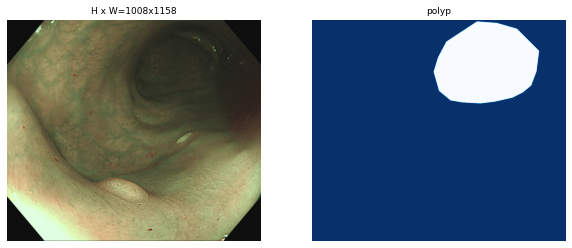

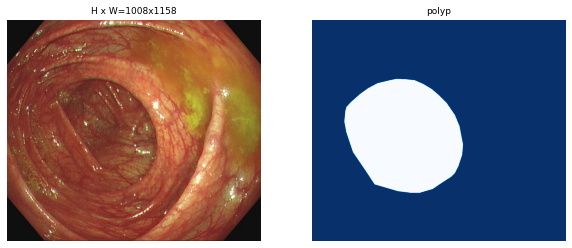

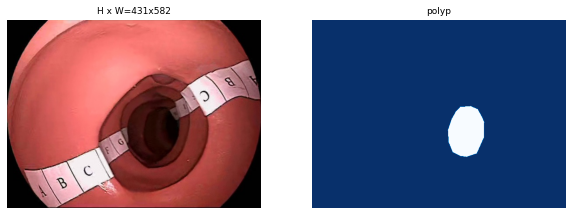

In [62]:
import utils
import visualize
image_ids = np.random.choice(train_set.image_ids, 3)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names,limit=1)

    class_ids = np.array([int(x) for x in class_ids])
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)

In [30]:
# define our model
from tensorflow import keras
from tensorflow.keras import layers

img_size = (200, 200)
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) #???
    x = layers.Rescaling(1./255)(inputs)
    
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
    
    outputs = layers.Conv2D(num_classes, 2, activation="softmax", padding="same")(x)
    
    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=2)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 256)       295168

2021-12-22 01:16:54.891067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 01:16:54.894745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 01:16:54.895089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-22 01:16:54.895576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [137]:
from tensorflow.keras.utils import load_img, img_to_array

input_imgs = np.zeros((len(train_set.image_info),) + img_size + (3,), dtype="float32")
targets = np.zeros((len(train_set.image_info),) + img_size + (1,), dtype="uint8")

for i in range(len(train_set.image_ids)):
    img = train_set.load_image(i).copy()
    input_imgs[i] = img.resize(img_size)
    m, _ = train_set.load_mask(i)
    targets[i] = m.resize(img_size)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [130]:
val_input_imgs = np.zeros((len(val_set.image_info),) + img_size + (3,), dtype="float32")
val_targets = np.zeros((len(val_set.image_info),) + img_size + (1,), dtype="bool")

for i in range(len(val_set.image_ids)):
    if i == 96 or i == 109:
        continue
    img = val_set.load_image(i).copy()
    val_input_imgs[i] = img.resize(img_size)
    m, _ = val_set.load_mask(i)
    val_targets[i] = m.resize(img_size)

In [132]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
save_best_only=True)
]
history = model.fit(input_imgs, targets,
epochs=50,
callbacks=callbacks,
batch_size=100,
validation_data=(val_input_imgs, val_targets))

Epoch 1/50


2021-12-22 03:24:13.244453: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 03:24:13.244505: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 03:24:13.244552: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 03:24:13.244578: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Alloc

7/8 [=========================>....] - ETA: 0s - loss: 0.5665

2021-12-22 03:24:19.237300: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-22 03:24:19.237356: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


8/8 [==============================] - 11s 883ms/step - loss: 0.5658 - val_loss: nan
Epoch 2/50
8/8 [==============================] - 3s 373ms/step - loss: 0.5561 - val_loss: nan
Epoch 3/50
8/8 [==============================] - 3s 373ms/step - loss: 0.5485 - val_loss: nan
Epoch 4/50
8/8 [==============================] - 3s 375ms/step - loss: 0.5416 - val_loss: nan
Epoch 5/50
8/8 [==============================] - 3s 374ms/step - loss: 0.5348 - val_loss: nan
Epoch 6/50
8/8 [==============================] - 3s 374ms/step - loss: 0.5283 - val_loss: nan
Epoch 7/50
8/8 [==============================] - 3s 374ms/step - loss: 0.5218 - val_loss: nan
Epoch 8/50
8/8 [==============================] - 3s 373ms/step - loss: 0.5153 - val_loss: nan
Epoch 9/50
8/8 [==============================] - 3s 372ms/step - loss: 0.5090 - val_loss: nan
Epoch 10/50
8/8 [==============================] - 3s 374ms/step - loss: 0.5027 - val_loss: nan
Epoch 11/50
8/8 [==============================] - 3s 373ms

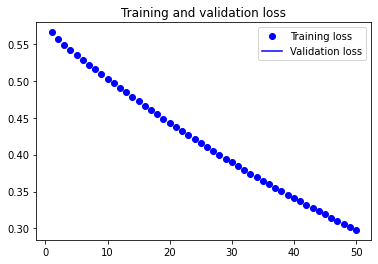

In [133]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()